# $M<\infty$

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [17]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from copy import deepcopy 
from icl.constants import DATA, DEVICE

from icl.analysis.utils import get_unique_run
from devinterp.mechinterp.hooks import hook

from icl.constants import FIGURES
from icl.figures.plotting import WIDTH, HEIGHT, FULL_WIDTH, FULL_HEIGHT

In [3]:
runs = [get_unique_run(
    "../sweeps/training-runs/archive/small-L-2.yaml", 
    task_config={"num_tasks": 2 ** m, "num_layers": 2},
    optimizer_config={"lr": 0.01}
) for m in range(21)]

/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/icl/analysis/baselines.py:165: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  ws_hat = torch.linalg.solve(LHS, RHS)   # BKDD^-1 @ BKD1 -> B K D 1


In [13]:
num_checkpoints = len(run.checkpointer)

In [4]:
from icl.train import Run

def get_task_prior(run: Run):
    tasks = run.pretrain_dist.task_distribution.tasks
    return tasks.mean(dim=0).cpu().numpy()

task_priors = [get_task_prior(run) for run in runs]
task_priors

[array([0.66135216, 0.2669241 , 0.06167726, 0.6213173 ], dtype=float32),
 array([ 0.1047231 ,  0.05039694, -0.73054564,  0.5015006 ], dtype=float32),
 array([-0.64004457,  0.15785366, -0.54566056, -0.7506001 ], dtype=float32),
 array([-0.15357773, -0.13482794, -0.6487049 , -0.44676146], dtype=float32),
 array([ 0.2879836 , -0.04962168, -0.35923088, -0.33100122], dtype=float32),
 array([ 0.1065192 , -0.07105163, -0.19645065, -0.10343701], dtype=float32),
 array([ 0.1533038 , -0.05998869,  0.05449546,  0.05901724], dtype=float32),
 array([ 0.02524932,  0.00033383,  0.01133076, -0.04779492], dtype=float32),
 array([-0.04439133,  0.09043673,  0.01479514,  0.01981971], dtype=float32),
 array([ 0.02031485, -0.03208904,  0.05423942,  0.02668095], dtype=float32),
 array([ 0.00477593,  0.02963829, -0.00531686,  0.00595533], dtype=float32),
 array([ 0.0093511 , -0.0006775 ,  0.01293248, -0.02175952], dtype=float32),
 array([ 0.00186392,  0.0115766 , -0.01183599, -0.03120732], dtype=float32),
 ar

In [7]:
# Let's generate these same plots and also look at their evolution. 
all_models = []

pbar = tqdm.tqdm(runs)

for i, run in enumerate(pbar):
    models = []

    for j, checkpoint in enumerate(run.checkpointer):
        m = deepcopy(run.model)
        m.load_state_dict(checkpoint["model"])
        models.append(m)

        pbar.set_description(f"({i}) {j}/{num_checkpoints}")

    all_models.append(models)

(20) 95/96: 100%|██████████| 21/21 [13:52<00:00, 39.67s/it]


In [8]:
with open(DATA / 'm-finite-models.pkl', 'wb') as f:
    torch.save(all_models, f)

In [5]:
with open(DATA / 'm-finite-models.pkl', 'rb') as f:
    all_models = torch.load(f)

# Progress measures

## Task-midpoint acquisition

In [14]:
from icl.constants import DEVICE
from icl.tasks import apply_transformations

task_midpoint_evals = []

pbar = tqdm.tqdm(zip(runs, all_models, task_priors), total=len(runs))
steps = list(sorted(run.checkpointer.file_ids))

for i, (run, models, task_prior) in enumerate(pbar):
    xs, ys = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys
    xs, ys = xs.to(DEVICE), ys.to(DEVICE)

    _task_prior = torch.tensor(task_prior).to(DEVICE).reshape(1, -1, 1).repeat(xs.shape[0], 1, 1)
    y_preds_with_taskprior = apply_transformations(_task_prior, xs, 0., DEVICE)

    for j, (step, model) in enumerate(zip(steps, models)):
        y_preds = model(xs, ys)
        y_pred_norms = (y_preds ** 2).sum(dim=1).mean(dim=0).item()
        y_pred_dist_to_prior = ((y_preds - y_preds_with_taskprior) ** 2).sum(dim=1).mean(dim=0).item()

        task_midpoint_evals.append({
            'step': step,
            'm': i,
            "M": 2 ** i,
            'y_pred_norms': y_pred_norms,
            'y_pred_dist_to_prior': y_pred_dist_to_prior,
        })

        pbar.set_description(f"({i}) {j}/{num_checkpoints}")

task_midpoint_evals = pd.DataFrame(task_midpoint_evals)

(20) 95/96: 100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


<ipython-input-18-2af19b89ecc7>:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(min_ylim, max_ylim)


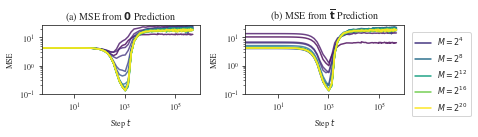

In [18]:
df = task_midpoint_evals.loc[task_midpoint_evals.m > 0]

fig, axes = plt.subplots(1, 2, figsize=(FULL_WIDTH, FULL_HEIGHT))

sns.lineplot(df, x='step', y='y_pred_norms', hue='m', palette='viridis', ax=axes[0], alpha=0.8)
sns.lineplot(df, x='step', y='y_pred_dist_to_prior', hue='m', palette='viridis', ax=axes[1], alpha=0.8)

axes[0].set_title("(a) MSE from $\mathbf{0}$ Prediction")
axes[1].set_title("(b) MSE from $\overline{\mathbf{t}}$ Prediction")

ylims1 = axes[0].get_ylim()
ylims2 = axes[1].get_ylim()

min_ylim = min(ylims1[0], ylims2[0])
max_ylim = max(ylims1[1], ylims2[1])

for ax in axes:
    ax.set_xlabel("Step $t$")
    ax.set_xscale("log")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.legend().remove()
    ax.set_ylim(min_ylim, max_ylim)

handles = axes[0].get_legend_handles_labels()[0]
ax.legend(handles=handles, labels=[f"$M = 2^{{{m}}}$" for m in [4, 8, 12, 16, 20]], bbox_to_anchor=(1.05, .9), loc='upper left', borderaxespad=0.)

fig.tight_layout()
fig.savefig(FIGURES / "m-finite/task-prior.pdf", bbox_inches='tight')
plt.show()

In [19]:
from icl.tasks import apply_transformations

ood_evals = []

pbar = tqdm.tqdm(zip(runs, all_models), total=len(runs))
B = 1024
K = 8
D = 4
MULTIPLIER = 5


for i, (run, models) in enumerate(pbar):
    ws = run.pretrain_dist.task_distribution.sample_tasks(B) # -> B D

    # sample i.i.d. inputs and outputs for each task according to the
    # regression model
    xs = torch.normal(
        mean=0.,
        std=1.,
        size=(B, K, D,),
        device=str(DEVICE),
    )
    ood_xs = MULTIPLIER * xs

    ys = apply_transformations(MULTIPLIER * ws, xs, 0.125, DEVICE)
    xs, ys = xs.to(DEVICE), ys.to(DEVICE)

    for j, model in enumerate(models):
        y_preds_ood_inputs = model(ood_xs, ys)
        y_preds_ood_tasks = model(xs, ys)

        loss_ood_inputs = ((y_preds_ood_inputs - ys) ** 2).sum(dim=1).mean(dim=0).item()
        loss_ood_tasks = ((y_preds_ood_tasks - ys) ** 2).sum(dim=1).mean(dim=0).item()
        
        ood_evals.append({
            'm': i,
            "M": 2 ** i,
            'step': steps[j],
            'loss_ood_inputs': loss_ood_inputs,
            'loss_ood_tasks': loss_ood_tasks,
        })

        pbar.set_description(f"({i}) {j}/{num_checkpoints}")

ood_evals = pd.DataFrame(ood_evals)
ood_evals

(20) 95/96: 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


,m,M,step,loss_ood_inputs,loss_ood_tasks
0,0,1,0,213.923370,210.027145
1,0,1,1,213.922943,210.026245
2,0,1,2,213.922302,210.024918
3,0,1,3,213.921478,210.023163
4,0,1,4,213.920380,210.020905
...,...,...,...,...,...
2011,20,1048576,459183,668.648621,493.298798
2012,20,1048576,469387,664.896729,486.411499
2013,20,1048576,479591,670.125977,490.965637
2014,20,1048576,489795,667.957886,486.508789


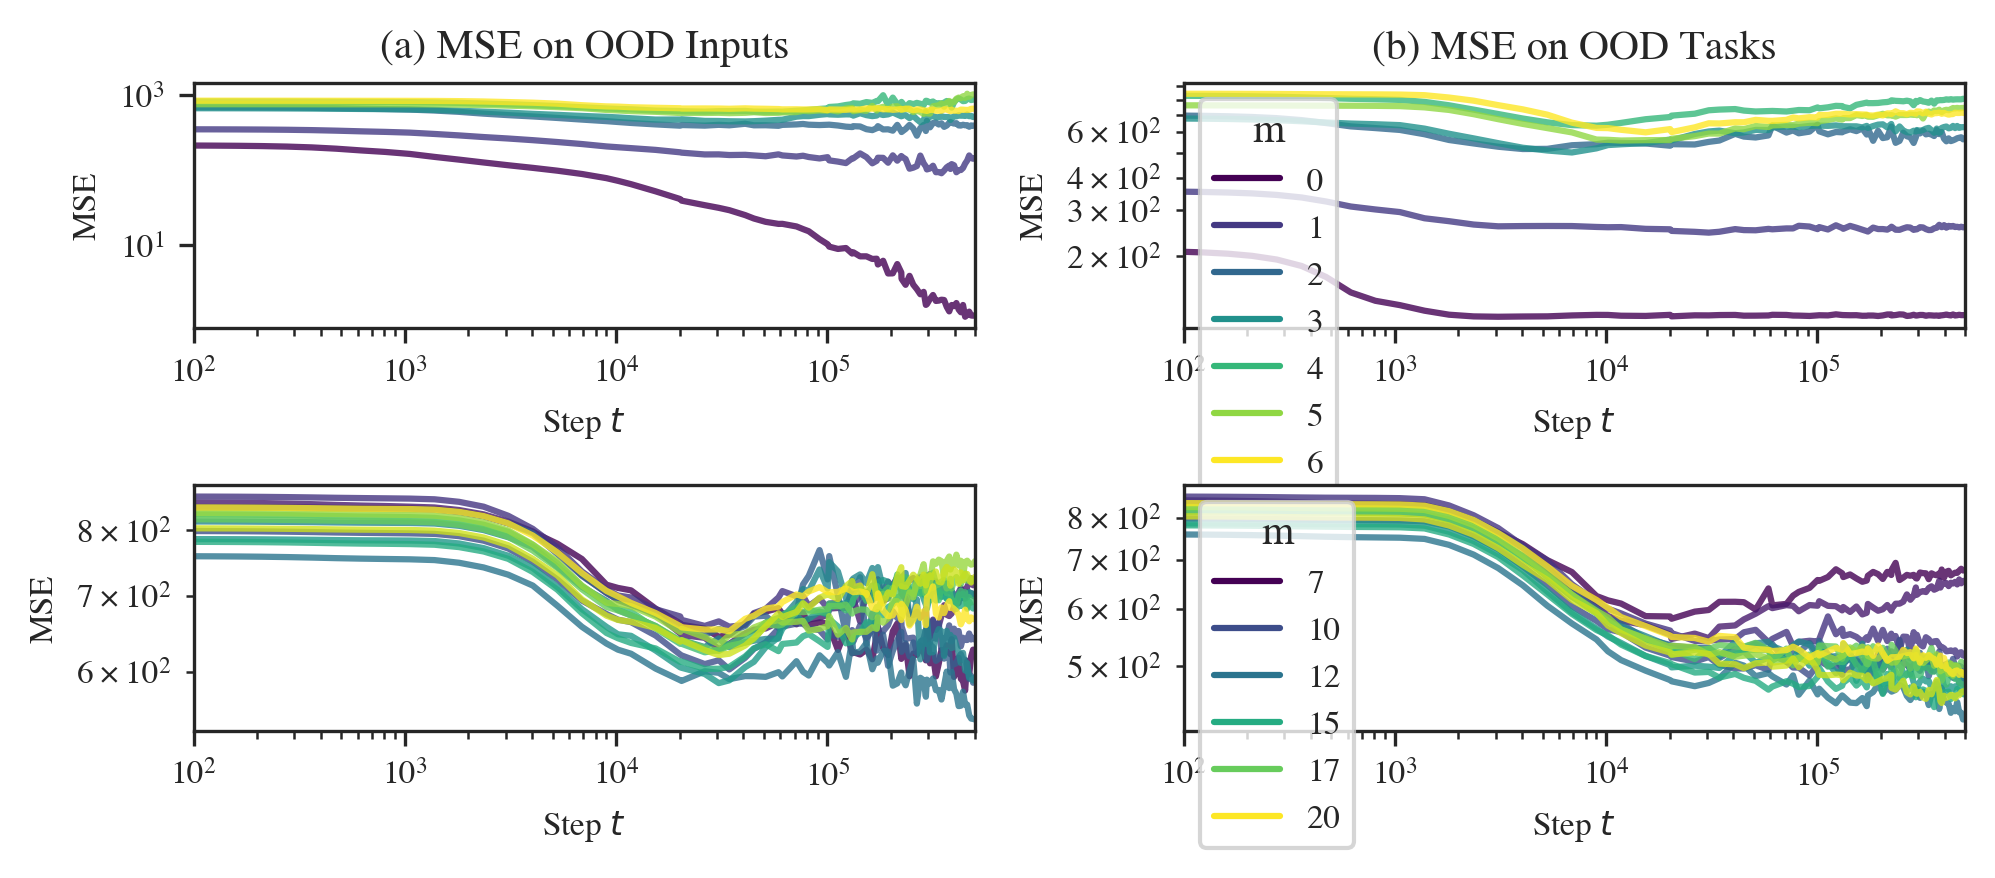

In [37]:
plt.rcParams['figure.dpi'] = 300

fig, axes = plt.subplots(2, 2, figsize=(FULL_WIDTH, FULL_HEIGHT * 1.5))

df = ood_evals.loc[ood_evals.m <= 6]

sns.lineplot(df, x='step', y='loss_ood_inputs', hue='m', palette='viridis', ax=axes[0, 0], alpha=0.8)
sns.lineplot(df, x='step', y='loss_ood_tasks', hue='m', palette='viridis', ax=axes[0, 1], alpha=0.8)

df = ood_evals.loc[ood_evals.m > 6]

sns.lineplot(df, x='step', y='loss_ood_inputs', hue='m', palette='viridis', ax=axes[1, 0], alpha=0.8)
sns.lineplot(df, x='step', y='loss_ood_tasks', hue='m', palette='viridis', ax=axes[1, 1], alpha=0.8)


axes[0, 0].set_title("(a) MSE on OOD Inputs")
axes[0, 1].set_title("(b) MSE on OOD Tasks")

ylims1 = axes[0, 0].get_ylim()
ylims2 = axes[0, 1].get_ylim()
ylims3 = axes[1, 0].get_ylim()
ylims4 = axes[1, 1].get_ylim()

min_ylim = min(ylims1[0], ylims2[0], ylims3[0], ylims4[0])
max_ylim = max(ylims1[1], ylims2[1], ylims3[1], ylims4[1])

for ax in axes.flatten():
    ax.set_xlabel("Step $t$")
    ax.set_xscale("log")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    # ax.legend().remove()
    # ax.set_ylim(min_ylim, max_ylim)
    ax.set_xlim(100, 500_000)

axes[0, 0].legend().remove()
axes[1, 0].legend().remove()
# handles = axes[0, 1].get_legend_handles_labels()[0]
# axes[0, 1].legend(handles=handles, labels=[f"$M = 2^{{{m}}}$" for m in [0, 2, 4, 6, 8, 10]], bbox_to_anchor=(1.05, .95), loc='upper left', borderaxespad=0.)
# handles = axes[1, 1].get_legend_handles_labels()[0]
# axes[1, 1].legend(handles=handles, labels=[f"$M = 2^{{{m}}}$" for m in [12, 13, 15, 16, 18, 19]], bbox_to_anchor=(1.05, .95), loc='upper left', borderaxespad=0.)

fig.tight_layout()
fig.savefig(FIGURES / "m-finite/ood-generalization.pdf", bbox_inches='tight')
plt.show()